In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
should_skip = True

In [3]:
#@title Install libraries
if not should_skip:
  !pip install -U -qq git+https://github.com/huggingface/diffusers.git
  !pip install -qq accelerate transformers ftfy
  !pip install -q gpustat gdown
  !pip install -q pytorch_lightning

In [4]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TVF
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
import sys

# https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unet_2d_condition.py#L175-L182
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from pytorch_lightning import seed_everything

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [5]:
if not should_skip:
    #@markdown Add here the URLs to the images of the concept you are adding. 3-5 should be fine
    train_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/2.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/3.jpeg",
    ]
    test_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/5.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/6.jpeg",
        ## You can add additional images here
    ]
#@title Download
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

if not should_skip:
    for save_path,urls in [("./my_concept",train_urls),("./my_concept_test",test_urls)]:
      images = list(filter(None,[download_image(url) for url in urls]))
      if not os.path.exists(save_path):
        os.mkdir(save_path)
      [image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]


if not should_skip:
    !gdown --id 1I8RMKQhPXntlRKorVNZ6yyNpfaOp8wNv
    mask_path="./my_concept_gt"
    !mkdir $mask_path/

    with open("my_concept_gt.zip","r") as f:
        pass
    !unzip -o my_concept_gt.zip

In [6]:
# %cd /content/
# sys.path.append("/content/slime-experiments/")

In [7]:
# !rm -rf slime-experiments/
# !git clone https://github.com/andrew-healey/slime-experiments
# !cd slime-experiments && git rev-parse --short HEAD

In [8]:
from slime.slime import SLiME
from slime.data.single_class import BinarySegmentationDataset,SegmentationDataModule

In [9]:
# Set the seed
seed_everything(42)

Seed set to 42


42

In [10]:
train_dataset = BinarySegmentationDataset(
    data_root="my_concept",
    mask_root="my_concept_gt",
)
test_dataset = BinarySegmentationDataset(
    data_root="my_concept_test",
    mask_root=None
)

data_module = SegmentationDataModule(
    train_dataset,
    test_dataset,
    iters_per_epoch=500
)

In [11]:
slime = SLiME(
    use_self_attn=False,
).cuda()

/usr/local/lib/python3.8/dist-packages/diffusers/configuration_utils.py:239: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [12]:
from pytorch_lightning import Trainer

trainer = Trainer(
    default_root_dir="run",
    limit_train_batches=1.0,
    num_sanity_val_steps=0,
    max_epochs=50,
    enable_checkpointing=False,
)

trainer.fit(slime, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type            | Params
-----------------------------------------------------------
0 | sd                     | StableDiffusion | 900 M 
1 | cross_layer_multiplier | Multiplier      | 32    
2 | self_layer_multiplier  | Multiplier      | 32    
3 | cross_map_multiplier   | Multiplier      | 4     
4 | pred_map_

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:211: You called `self.log('mse_loss', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
`Trainer.fit` stopped: `max_epochs=50` reached.


In [13]:
slime.cuda()

SLiME(
  (sd): StableDiffusion(
    (vae): AutoencoderKL(
      (encoder): Encoder(
        (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (down_blocks): ModuleList(
          (0): DownEncoderBlock2D(
            (resnets): ModuleList(
              (0-1): 2 x ResnetBlock2D(
                (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
                (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (nonlinearity): SiLU()
              )
            )
            (downsamplers): ModuleList(
              (0): Downsample2D(
                (conv): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(2, 2))
              )
            )
          )
          (

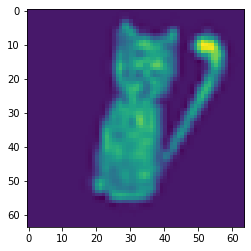

In [14]:
import matplotlib.pyplot as plt
plt.imshow(slime.latest_preds[-1].swapaxes(1,2).reshape((2,2,64,64))[0,1])

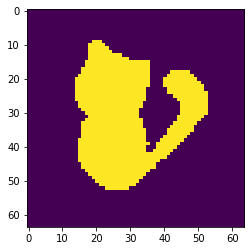

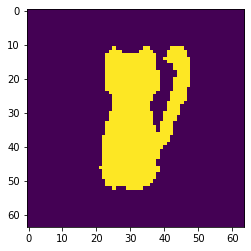

In [15]:
#@title Infer on test set
out_mask = None
loader = data_module.test_dataloader()
for i,batch in enumerate(loader):
  out_mask = slime.predict_step(batch,i).cpu().numpy()
  break

import matplotlib.pyplot as plt
for i in range(len(out_mask)):
  plt.imshow(out_mask[i].reshape((64,64)))
  plt.show()

(970, 4096)
sums
[ 6.283964  6.352625  6.312261 ... 22.41182  22.25228  22.190355]
[0.92322344 0.9173523  0.91227794 ... 0.99233824 0.9850538  1.0000879 ]
[0.80508894 0.81011266 0.8039311  ... 1.0516762  1.0427496  1.0538116 ]


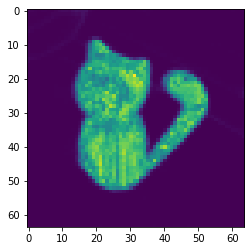

In [16]:
# visualize self-attn maps

self_attn_maps = slime.latest_selfs

# pick a random token to visualize

batch_num = 0
layer_num = 0

mask = out_mask[batch_num].astype(bool)==1

layer = self_attn_maps[layer_num]
num_tokens = layer.shape[1]
token_num = random.randint(0, num_tokens - 1)

im_dims = int(math.sqrt(layer.shape[-1]))

print(layer[batch_num,mask].shape)

raw_map = layer[batch_num]
# make attn map cols sum to 1
attn_map = (raw_map / raw_map.sum(axis=1)) 
big_attn_map = attn_map
# raise matrix to power of 2 (with matrix multiplication)
for i in range(5):
    big_attn_map = big_attn_map @ attn_map
print("sums")
print(raw_map.sum(axis=1))
print(attn_map.sum(axis=1))
print(big_attn_map.sum(axis=1))

final_attn_map = attn_map[mask].mean(axis=0).reshape(im_dims, im_dims).copy()
#  = attn_map / attn_map.max()
# attn_map[token_num // im_dims, token_num % im_dims] = 1.0

plt.imshow(final_attn_map)

In [17]:
eigenvals, eigenvectors = np.linalg.eig(attn_map)
eigenvals = eigenvals.real
print(eigenvectors)

[[-0.00585012+0.j  0.04073544+0.j -0.03707819+0.j ... -0.00170415+0.j
   0.00029738+0.j  0.00068822+0.j]
 [-0.00591405+0.j  0.04197248+0.j -0.03916426+0.j ... -0.00859544+0.j
  -0.00341293+0.j -0.01126665+0.j]
 [-0.00587647+0.j  0.04178163+0.j -0.03917794+0.j ...  0.00991409+0.j
   0.00286828+0.j  0.01101613+0.j]
 ...
 [-0.02086453+0.j -0.00276676+0.j -0.00046435+0.j ...  0.01882767+0.j
   0.00976013+0.j  0.02771928+0.j]
 [-0.020716  +0.j -0.00273977+0.j -0.00045018+0.j ... -0.01089631+0.j
  -0.00781418+0.j -0.01386634+0.j]
 [-0.02065836+0.j -0.00266089+0.j -0.00041965+0.j ...  0.00183336+0.j
   0.00924869+0.j -0.00516382+0.j]]


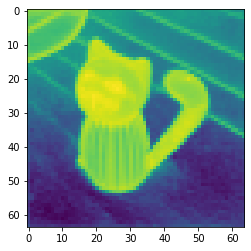

In [18]:
eigenvecs = eigenvectors[:,0].real.reshape(im_dims, im_dims)
plt.imshow(eigenvecs)